# Geochemistry

To start let's load a geochemistry dataset. In pandas the datasets are stored as `pandas.DataFrame` objects if 2D or as `pandas.Seriesobjects` if 1D (vector). One advantage of pandas for handling tabular data and data analysis compared to numpy is that we can access columns by their names instead of having to memorize indexes.

In an object-oriented framework such as Python, objects can have associated **methods** and **attributes**. This was already the case for numpy, but is also key in the pandas `DataFrame` and `Series` objects.

A **method** is like a function specific for an object. Once we have an object of a certain class instantiated (which just means we declared a variable of a certain class), we can call methods for that objects. We call a method by using `object.method()` notation. Sometimes methods take arguments, just like functions.

An **attribute** is a static property of the object. So instead of being called by placing parentheses after the name, we just use `object.attribute` to visualize the attributes.

As with anything, examples will make it clearer

In [2]:
# For data processing
import pandas as pd
import numpy as np
from pyrolite.geochem.norm import all_reference_compositions,get_reference_composition

# For visualization
import seaborn as sns
import pyrolite.plot
import matplotlib.pyplot as plt
import os


## Import and clean datasets
We're working with data from the Antrim Volcanic Plateau in the NT

In [16]:
files_path = "Kalkarindji LIP_Antrim Plateau Volcanics"
Litho = pd.read_excel(os.path.join(files_path,"Antrim DH geology.xls"))
Maj = pd.read_excel(os.path.join(files_path,"ANT1&2 original majors.xls"), header = 1)
TE = pd.read_excel(os.path.join(files_path,"Ant1&2 original traces.xls"))


TE = TE.rename({"ELEMENTS":"ID"}, axis = 1)
Maj_LOD = Maj.iloc[1,3:]
TE_LOD = TE.iloc[1,3:]
TE_Dup = TE.iloc[36:38,:]
TE_Standards = TE.iloc[40:43]

Maj = Maj.iloc[4:,:]
TE = TE.iloc[5:34,:]
Maj["CentrePoint"] = Maj.Interval.str.split("-").apply(lambda x: (float(x[0]) + float(x[1]))/2).round(2)
TE["CentrePoint"] = TE.Interval.str.split("-").apply(lambda x: (float(x[0]) + float(x[1]))/2).round(2)
Maj = Maj.rename({'AUSQUEST 22/11/02   251102':"ID"}, axis = 1)
TraceElements = TE.pyrochem.list_elements


 

In [189]:
Standards = pd.DataFrame(
    [  
        [
            340.,122.,2.8,12,7,18.2,14.2,2.,14.,10.6,4.3,
            58.,2.1,13.,57.,9.,15.,55.,12.7,1191.,0.9,2.6,
            1.4,2.3,0.8,8.,119.,14.8,93.,517.
        ]
    ],
    columns=TraceElements,
    index=["SY-4"]
)
Standards.index.name = "ID"

In [215]:
def RSD(el1,el2):
    return np.std([el1,el2])/np.mean([el1,el2]) * 100

def check_duplicates(dataset, duplicates, columns, ID_column = "ID", plot = True):

    Dup_IDs = duplicates["ID"].values
    Dup_checks = np.empty(shape = (len(Dup_IDs),len(columns)))
    for i,idx in enumerate(Dup_IDs):
        data = dataset.loc[dataset["ID"]==idx,columns]
        dups = duplicates.loc[duplicates["ID"]==idx,columns]
        Dup_checks[i] = list(map(RSD, data.values[0], dups.values[0]))\
        

    if plot:
        fig, ax = plt.subplots(figsize = (10,4))

        for i in range(len(Dup_checks)):
            ax.scatter(
                np.arange(Dup_checks.shape[1]),
                Dup_checks[i],
                label = Dup_IDs[i]
            )

        ax.axhline(
            5, ls = "--", color = "black"
        )

        ax.set_xticks(
            np.arange(TE.loc[:,"Ba":"Zr"].values.shape[1]),
            labels = TE.loc[:,"Ba":"Zr"].columns
        );

        ax.set(xlabel = "Element", ylabel = "RSD (%)");
        ax.legend();

def check_standards(Meas_standards, standards, columns, ID_column = "ID"):

    Std_ids = standards.index
 
    _, ax = plt.subplots()

    for i, idx in enumerate(Std_ids):

        ax.scatter(
            Meas_standards.loc[Meas_standards[ID_column]==idx,columns].values[0],
            standards.loc[standards.index==idx,columns].values[0],
            label = Std_ids[i]
        )
    
    ax.plot(
        [0,max(Meas_standards.loc[Meas_standards[ID_column]==idx,columns].values[0].max(),
               standards.loc[standards.index==idx,columns].values[0].max())],
        [0,max(Meas_standards.loc[Meas_standards[ID_column]==idx,columns].values[0].max(),
               standards.loc[standards.index==idx,columns].values[0].max())],
        color = "black", ls = ":"
    )

    ax.set(
        xlabel = "Measured", ylabel = "Reference"
    );
    ax.legend();



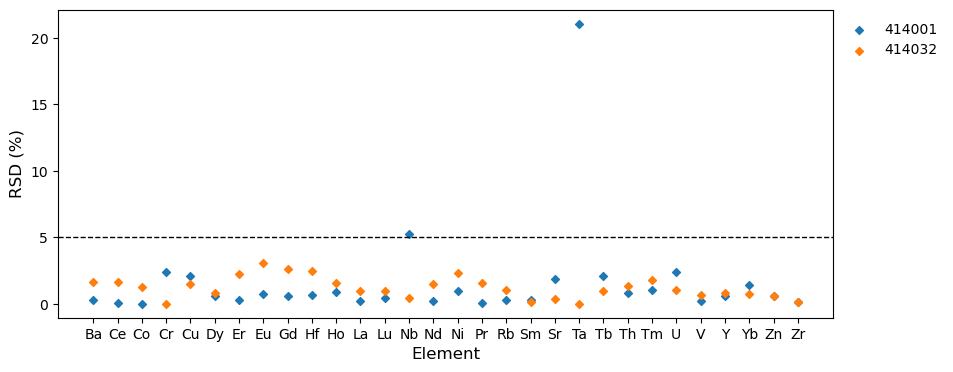

In [191]:
check_duplicates(TE,TE_Dup,TraceElements)

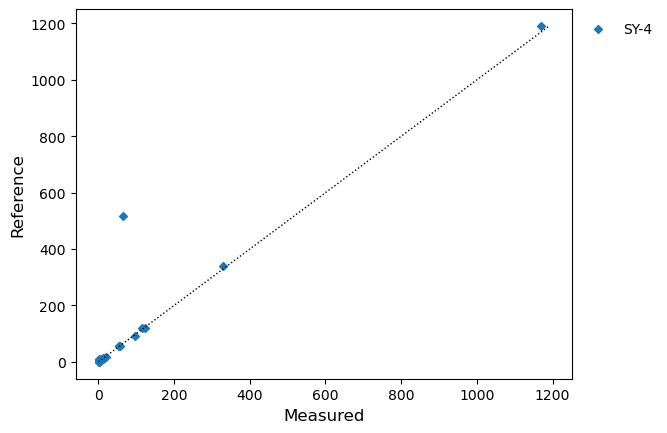

In [216]:
check_standards(TE_Standards, Standards, TraceElements)

## Merging the major and trace element datasets

In [29]:
df = Maj.merge(TE[["ID",*TE.pyrochem.list_elements]], on = "ID")
df

,ID,Location,Interval,Al2O3,CaO,Fe2O3,K2O,MgO,MnO,Na2O,...,Ta,Tb,Th,Tm,U,V,Y,Yb,Zn,Zr
0,414001,ANT001,104.3-104.5,14.99,7.88,10.42,1.72,5.1,0.19,3.33,...,0.92,0.917,7.85,0.5,1.23,262,29.1,3.18,87,160.9
1,414002,ANT001,149.5-149.7,15.46,8.17,9.32,1.7,5.04,0.13,3.03,...,0.8,0.83,9.59,0.45,1.7,187,27.75,2.91,97,153
2,414003,ANT001,198.65-198.85,14.23,7.13,9.57,1.95,4.98,0.15,3.46,...,0.9,1.015,11.2,0.53,2.07,200,30.4,3.34,105,169.7
3,414004,ANT001,250.25-250.45,15.67,9.02,9.25,1.54,5.01,0.14,2.48,...,0.73,0.877,9.24,0.47,1.56,188,27.9,2.97,87,151.5
4,414005,ANT001,308.4-308.65,14.23,6.92,11.22,2.27,5.08,0.18,4.33,...,0.68,0.969,8.15,0.54,1.35,287,31.3,3.48,74,173.7
5,414006,ANT001,348.7-348.9,13.4,6.04,12.4,1.49,3.95,0.17,4.74,...,0.74,0.926,11.67,0.5,1.83,359,30.22,3.16,91,150.5
6,414007,ANT001,395.05-395.25,14.22,6.96,11.23,1.56,5.55,0.16,4.94,...,0.59,0.748,8.14,0.4,1.3,292,24.55,2.63,85,114.4
7,414008,ANT001,415.8-416.0,12.73,7.5,13.09,1.65,4.04,0.18,4.71,...,0.71,1.046,9.85,0.57,1.63,302,33.8,3.73,69,166.2
8,414009,ANT001,450.2-450.4,13.46,7.29,13.25,1.77,4.41,0.2,3.72,...,0.7,1.07,9.27,0.57,1.58,309,33.7,3.56,147,164.6
9,414010,ANT001,465.6-465.8,13.31,7.26,13.63,1.78,4.26,0.2,3.34,...,0.78,1.098,10.09,0.59,1.79,311,35.58,3.73,115,177.6


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           29 non-null     object 
 1   Location     29 non-null     object 
 2   Interval     29 non-null     object 
 3   Al2O3        29 non-null     object 
 4   CaO          29 non-null     object 
 5   Fe2O3        29 non-null     object 
 6   K2O          29 non-null     object 
 7   MgO          29 non-null     object 
 8   MnO          29 non-null     object 
 9   Na2O         29 non-null     object 
 10  P2O5         29 non-null     object 
 11  SO3          29 non-null     object 
 12  SiO2         29 non-null     object 
 13  TiO2         29 non-null     object 
 14  LOI          29 non-null     object 
 15  Total        29 non-null     object 
 16  CentrePoint  29 non-null     float64
 17  Ba           29 non-null     object 
 18  Ce           29 non-null     object 
 19  Co        

We can see the element columns are all classified as containing object types. That is basically a catch-all bag of mixed data types. We want the data to be numeric. The issue is the existence of values below LOD, denoted as "<", which python cannot interpret as a number. There are multiple ways to overcome this

,Al2O3,CaO,Fe2O3,K2O,MgO,MnO,Na2O,P2O5,SO3,SiO2,...,Ta,Tb,Th,Tm,U,V,Y,Yb,Zn,Zr
0,14.99,7.88,10.42,1.72,5.10,0.19,3.33,0.15,0.06,52.71,...,0.92,0.917,7.85,0.50,1.23,262,29.10,3.18,87,160.9
1,15.46,8.17,9.32,1.70,5.04,0.13,3.03,0.14,0.14,54.90,...,0.80,0.830,9.59,0.45,1.70,187,27.75,2.91,97,153.0
2,14.23,7.13,9.57,1.95,4.98,0.15,3.46,0.16,0.01,55.66,...,0.90,1.015,11.20,0.53,2.07,200,30.40,3.34,105,169.7
3,15.67,9.02,9.25,1.54,5.01,0.14,2.48,0.14,0.02,54.51,...,0.73,0.877,9.24,0.47,1.56,188,27.90,2.97,87,151.5
4,14.23,6.92,11.22,2.27,5.08,0.18,4.33,0.16,0.05,52.66,...,0.68,0.969,8.15,0.54,1.35,287,31.30,3.48,74,173.7
5,13.40,6.04,12.40,1.49,3.95,0.17,4.74,0.13,0.06,54.58,...,0.74,0.926,11.67,0.50,1.83,359,30.22,3.16,91,150.5
6,14.22,6.96,11.23,1.56,5.55,0.16,4.94,0.10,0.75,52.54,...,0.59,0.748,8.14,0.40,1.30,292,24.55,2.63,85,114.4
7,12.73,7.50,13.09,1.65,4.04,0.18,4.71,0.17,3.24,50.96,...,0.71,1.046,9.85,0.57,1.63,302,33.80,3.73,69,166.2
8,13.46,7.29,13.25,1.77,4.41,0.20,3.72,0.17,0.22,52.88,...,0.70,1.070,9.27,0.57,1.58,309,33.70,3.56,147,164.6
9,13.31,7.26,13.63,1.78,4.26,0.20,3.34,0.18,0.68,53.03,...,0.78,1.098,10.09,0.59,1.79,311,35.58,3.73,115,177.6


In [35]:
# Identifying data < LOD
df = df.replace(
    to_replace=[
        x for x in df.values.flatten() if str(x).startswith("<")
    ],
    value=np.nan
) # we'll replace values < LOD for nans; that is an option. One could also choose to treat them as half the LOD, etc.
# It is important to note that any choice will introduce some sort of bias to the data

# We can then convert the column types to floating point numbers 
df.pyrochem.compositional = df.pyrochem.compositional.astype("float")
df.pyrochem.compositional.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al2O3   29 non-null     float64
 1   CaO     29 non-null     float64
 2   Fe2O3   29 non-null     float64
 3   K2O     29 non-null     float64
 4   MgO     29 non-null     float64
 5   MnO     29 non-null     float64
 6   Na2O    29 non-null     float64
 7   P2O5    29 non-null     float64
 8   SO3     26 non-null     float64
 9   SiO2    29 non-null     float64
 10  TiO2    29 non-null     float64
 11  LOI     29 non-null     float64
 12  Ba      29 non-null     float64
 13  Ce      29 non-null     float64
 14  Co      29 non-null     float64
 15  Cr      29 non-null     float64
 16  Cu      29 non-null     float64
 17  Dy      29 non-null     float64
 18  Er      29 non-null     float64
 19  Eu      29 non-null     float64
 20  Gd      29 non-null     float64
 21  Hf      29 non-null     float64
 22  Ho  

## Now we can start plotting our data
### Harker plot
$MgO$ vs. major elements

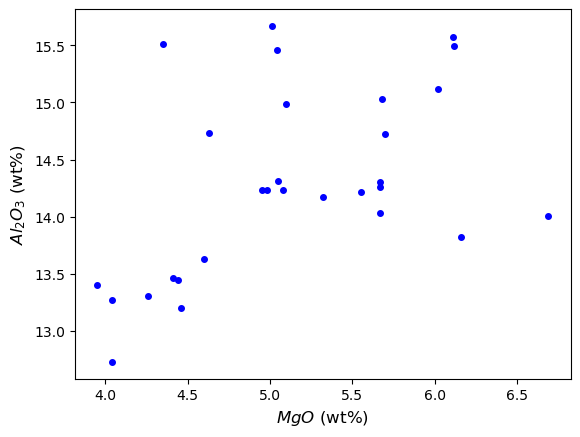

In [38]:
fig, ax = plt.subplots()

ax.scatter(
    df["MgO"], # x-variable
    df["Al2O3"], # y-variable
    marker="o",
    color="blue"
)

ax.set_xlabel("$MgO$ (wt%)")
ax.set_ylabel("$Al_{2}O_{3}$ (wt%)")

plt.show()

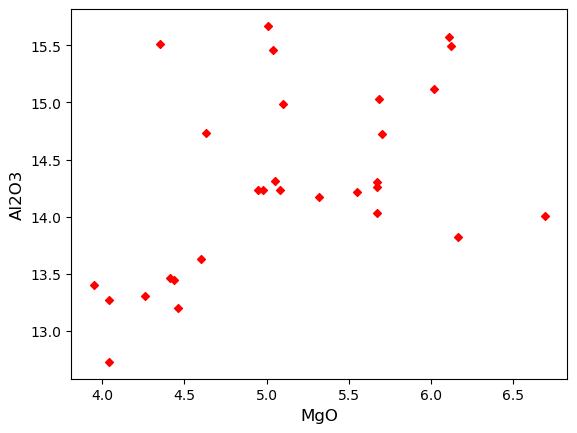

In [39]:
def Harker(df, element, ax, **kwargs):  #kwargs are the style changes that will be passed on to the ax.scatter() call

  x = df["MgO"],
  y = df[element],

  ax.scatter(
      x,y,
      **kwargs
  )
  ax.set(xlabel="MgO", ylabel=element)


fig, ax = plt.subplots()
Harker(df,"Al2O3",ax, color="red") # color is a kwarg

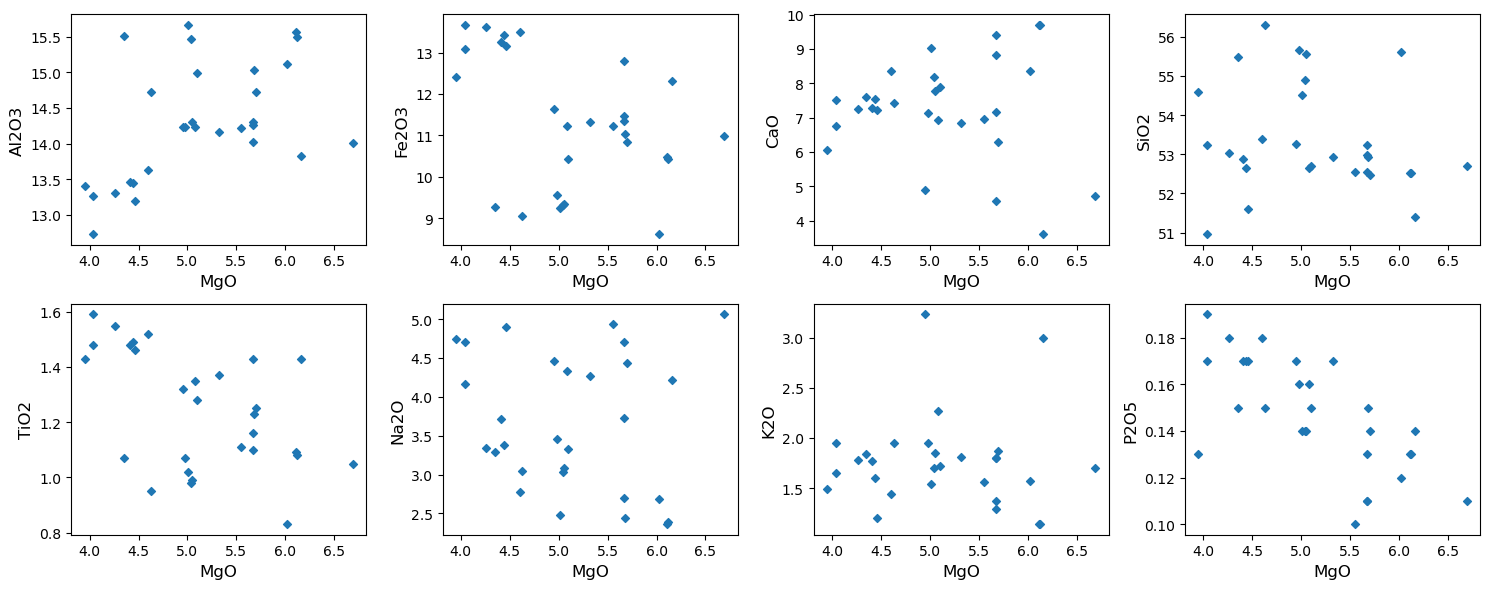

In [41]:
# We will use 8 major elements, which we will split up in 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(15, 6))


elements = ["Al2O3", "Fe2O3", "CaO", "SiO2",
            "TiO2", "Na2O", "K2O", "P2O5"]

for ax, element in zip(axes.flatten(), elements):
  Harker(df, element, ax)

plt.tight_layout()

#### Optional questions
- How can we use a different element as x-axis?
- Is there a way to make the x-label appear only on the lower plots?

## Calculating new variables:
With pandas we can not only visualize tabulat data, but also evaluate expressions and calculate new variables, among other things. For this example we will calculate Total Alkalis ($K_{2}O + Na_{2}O$) so we can later use this variable for classification in a TAS diagram. We can achieve this in multiple ways

In [43]:
#df["Na2O + K2O"] = df["Na2O"] + df["K2O"]
#df["Na2O + K2O"] = df.eval("Na2O + K2O")
df["Na2O + K2O"] = df.apply(lambda x: x["K2O"]+x["Na2O"], axis=1)
df["Na2O + K2O"].head()

0    5.05
1    4.73
2    5.41
3    4.02
4    6.60
Name: Na2O + K2O, dtype: float64

In [42]:
REE = df.pyrochem.REE

REE["La/Sm"] = REE.eval("La/Sm")
# using the .eval() method to calculate a new ratio
# REE["La/Sm"] = REE["La"].values/REE["Sm"].values would also work


REE["Nd/10"] = REE["Nd"].apply(lambda x: x/10)
# using the .apply method and an anonymous function to calculate a new variable
# REE["Nd/10"] = REE.eval("Nd/10") also works
# REE["Nd/10"] = REE["Nd"].values/10 also works


REE["Gd/Yb"] = REE.eval("Gd/Yb")

C:\Users\piero\AppData\Local\Temp\ipykernel_18876\1727205320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REE["La/Sm"] = REE.eval("La/Sm")
C:\Users\piero\AppData\Local\Temp\ipykernel_18876\1727205320.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REE["Nd/10"] = REE["Nd"].apply(lambda x: x/10)
C:\Users\piero\AppData\Local\Temp\ipykernel_18876\1727205320.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Now we can use the TAS template provided by `pyrolite`

In [46]:
from pyrolite.plot.templates import TAS, pearceThNbYb, pearceTiNbYb

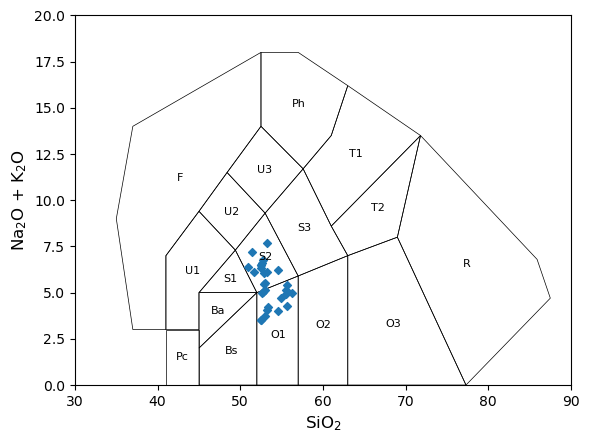

In [45]:
ax = TAS(linewidth = 0.5, add_labels = True)

ax.scatter(
    df["SiO2"],
    df["Na2O + K2O"]
)

plt.show()

<Axes: xlabel='Nb/Yb', ylabel='TiO$_2$/Yb'>

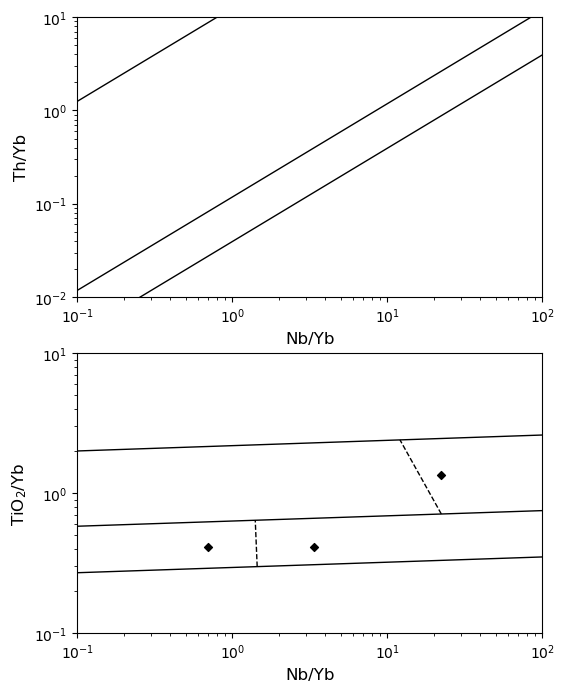

In [51]:
## other templates
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (6,8))

pearceThNbYb(ax1)
pearceTiNbYb(ax2)

In [52]:
from pyrolite.util.classification import TAS as TAS_clf


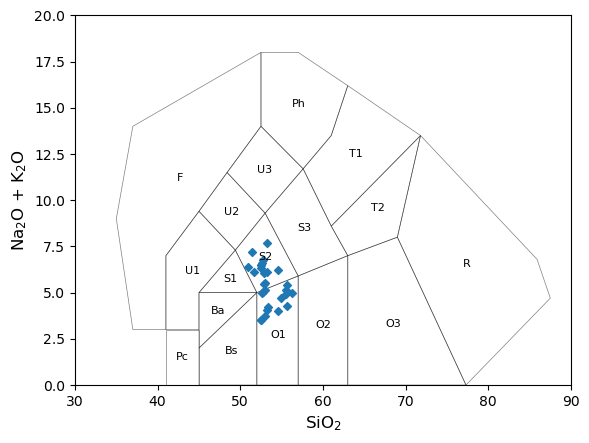

In [53]:
cm = TAS_clf()

fig, ax = plt.subplots(1)
cm.add_to_axes(ax, alpha=0.5, linewidth=0.5, zorder=-1, add_labels=True)
df[["SiO2", "Na2O + K2O"]].pyroplot.scatter(ax=ax, axlabels=False)
plt.show()

In [54]:

### This is a technicality that is not strictly necessary

def remove_newlines(data):
    # Iterate through the dictionary keys and values
    for key, value in data.items():
        # Check if the value has a "name" key and if the name is a list
        if isinstance(value['name'], list):
            # Remove '\n' from each string in the list
            value['name'] = [name.replace('\n', ' ') for name in value['name']]
        elif isinstance(value['name'], str):
            # If it's a string (in cases like 'nan'), remove '\n' from the string
            value['name'] = value['name'].replace('\n', ' ')

remove_newlines(cm.fields)

In [55]:
df["TAS"] = cm.predict(df)
df["Rocknames"] = df.TAS.apply(lambda x: cm.fields.get(x, {"name": None})["name"][0])
df["Rocknames"].sample(10)  # randomly check 10 sample rocknames

18             Basaltic Andesite
21    Basaltic  Trachy- andesite
9              Basaltic Andesite
13             Basaltic Andesite
4     Basaltic  Trachy- andesite
27             Basaltic Andesite
22    Basaltic  Trachy- andesite
8     Basaltic  Trachy- andesite
11    Basaltic  Trachy- andesite
14             Basaltic Andesite
Name: Rocknames, dtype: object

<Axes: xlabel='SiO2', ylabel='Na2O + K2O'>

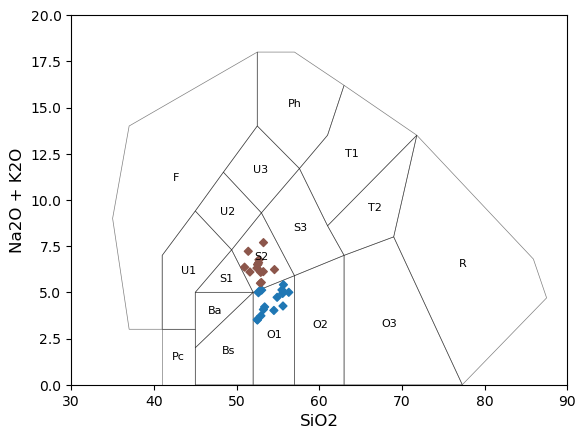

In [56]:
fig, ax = plt.subplots(1)
cm.add_to_axes(ax, alpha=0.5, linewidth=0.5, zorder=-1, add_labels=True)
df[["SiO2", "Na2O + K2O"]].pyroplot.scatter(ax=ax, c=df["TAS"]) # Just set a random color for each unique code

We can define our own legend and color scheme. `matplotlib` has a long list of [named colors](https://matplotlib.org/stable/gallery/color/named_colors.html), but you can also set colors as RGB values or HEX values. There is also a wide variety of marker types, as well as it being possible to create custom markers.

In [57]:
# First let's check which lithologies are present
df["Rocknames"].value_counts()

Rocknames
Basaltic Andesite             15
Basaltic  Trachy- andesite    14
Name: count, dtype: int64

In [58]:
Colors = [
    "forestgreen",
    "slategray"
]
Color_dict = dict(zip(df["Rocknames"].unique(),Colors))
Color_dict

{'Basaltic Andesite': 'forestgreen', 'Basaltic  Trachy- andesite': 'slategray'}

## Filtering:
We can also use pandas to filter datasets quickly using logic operators.

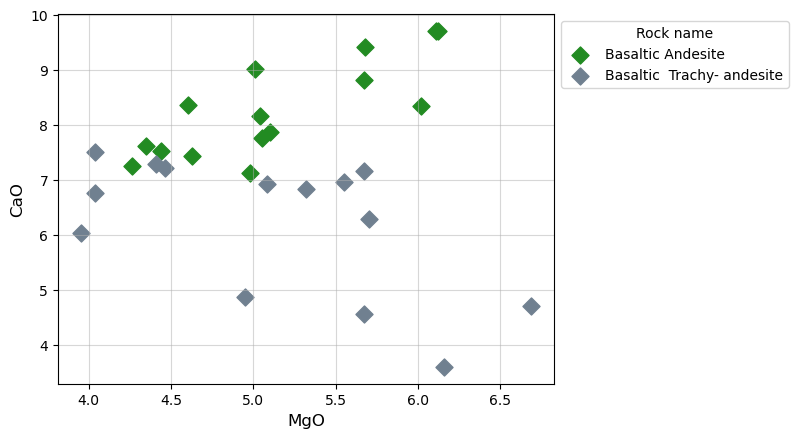

In [61]:
fig, ax = plt.subplots()

ax.grid(alpha=0.5)

# now we just need to loop over the rock names. Because the symbology is
# associated to the name we can use that to call the unique properties of
# each lithology using the dictionaries

for rock in df["Rocknames"].unique():
  ax.scatter(
      df.loc[df["Rocknames"]==rock,"MgO"], #filtering the dataset
      df.loc[df["Rocknames"]==rock,"CaO"],
      color=Color_dict[rock],
      marker="D",
      s=75,
      label=rock
  )

ax.set(xlabel = "MgO", ylabel = "CaO")

ax.legend(title = "Rock name", frameon = True)

In [ ]:
# We can also use numerical filters and combine different filters using & (and), and | (or)
df_filtered = df.loc[(df["MgO"] >= 5) & (df["La"] >= 20)]
df_filtered

,ID,Location,Interval,Al2O3,CaO,Fe2O3,K2O,MgO,MnO,Na2O,...,Tm,U,V,Y,Yb,Zn,Zr,Na2O + K2O,TAS,Rocknames
0,414001,ANT001,104.3-104.5,14.99,7.88,10.42,1.72,5.10,0.19,3.33,...,0.50,1.23,262.0,29.10,3.18,87.0,160.9,5.05,O1,Basaltic Andesite
1,414002,ANT001,149.5-149.7,15.46,8.17,9.32,1.70,5.04,0.13,3.03,...,0.45,1.70,187.0,27.75,2.91,97.0,153.0,4.73,O1,Basaltic Andesite
3,414004,ANT001,250.25-250.45,15.67,9.02,9.25,1.54,5.01,0.14,2.48,...,0.47,1.56,188.0,27.90,2.97,87.0,151.5,4.02,O1,Basaltic Andesite
4,414005,ANT001,308.4-308.65,14.23,6.92,11.22,2.27,5.08,0.18,4.33,...,0.54,1.35,287.0,31.30,3.48,74.0,173.7,6.60,S2,Basaltic Trachy- andesite
13,414019,ANT002,179.4-179.6,14.31,7.77,9.34,1.85,5.05,0.15,3.09,...,0.51,1.96,177.0,29.77,3.16,79.0,160.5,4.94,O1,Basaltic Andesite
15,414021,ANT002,224.8-225.0,15.12,8.35,8.61,1.57,6.02,0.14,2.69,...,0.43,1.76,165.0,25.99,2.77,70.0,143.4,4.26,O1,Basaltic Andesite
16,414022,ANT002,247.5-247.7,15.57,9.71,10.47,1.14,6.11,0.15,2.36,...,0.45,1.68,194.0,27.12,2.89,72.0,143.2,3.50,O1,Basaltic Andesite
19,414025,ANT002,327.4-327.6,14.17,6.83,11.33,1.81,5.32,0.20,4.27,...,0.53,1.31,270.0,30.83,3.37,76.0,169.4,6.08,S2,Basaltic Trachy- andesite
25,414031,ANT002,431.2-431.4,14.03,4.57,12.80,1.80,5.67,0.15,4.71,...,0.51,1.90,383.0,30.62,3.23,111.0,140.3,6.51,S2,Basaltic Trachy- andesite


In [ ]:
# SQL-type query
df.query("MgO >= 5")

In [65]:
# For columns with string entries we can check if the string
# contains a certain sub-string
df.loc[df["Rocknames"].str.contains("Trachy")]

,ID,Location,Interval,Al2O3,CaO,Fe2O3,K2O,MgO,MnO,Na2O,...,Tm,U,V,Y,Yb,Zn,Zr,Na2O + K2O,TAS,Rocknames
4,414005,ANT001,308.4-308.65,14.23,6.92,11.22,2.27,5.08,0.18,4.33,...,0.54,1.35,287.0,31.30,3.48,74.0,173.7,6.60,S2,Basaltic Trachy- andesite
5,414006,ANT001,348.7-348.9,13.40,6.04,12.40,1.49,3.95,0.17,4.74,...,0.50,1.83,359.0,30.22,3.16,91.0,150.5,6.23,S2,Basaltic Trachy- andesite
6,414007,ANT001,395.05-395.25,14.22,6.96,11.23,1.56,5.55,0.16,4.94,...,0.40,1.30,292.0,24.55,2.63,85.0,114.4,6.50,S2,Basaltic Trachy- andesite
7,414008,ANT001,415.8-416.0,12.73,7.50,13.09,1.65,4.04,0.18,4.71,...,0.57,1.63,302.0,33.80,3.73,69.0,166.2,6.36,S2,Basaltic Trachy- andesite
8,414009,ANT001,450.2-450.4,13.46,7.29,13.25,1.77,4.41,0.20,3.72,...,0.57,1.58,309.0,33.70,3.56,147.0,164.6,5.49,S2,Basaltic Trachy- andesite
10,414011,ANT001,432.7-432.9,13.27,6.76,13.68,1.95,4.04,0.20,4.17,...,0.61,1.67,316.0,36.76,3.88,128.0,177.8,6.12,S2,Basaltic Trachy- andesite
11,414017,ANT002,117.95-118.15,14.72,6.29,10.85,1.87,5.70,0.16,4.44,...,0.47,1.12,262.0,27.84,2.99,85.0,145.7,6.31,S2,Basaltic Trachy- andesite
19,414025,ANT002,327.4-327.6,14.17,6.83,11.33,1.81,5.32,0.20,4.27,...,0.53,1.31,270.0,30.83,3.37,76.0,169.4,6.08,S2,Basaltic Trachy- andesite
20,414026,ANT002,334.0-334.2,14.23,4.88,11.64,3.23,4.95,0.25,4.46,...,0.48,1.59,287.0,29.37,3.09,81.0,145.0,7.69,S2,Basaltic Trachy- andesite
21,414027,ANT002,349.8-350.0,14.01,4.71,10.98,1.70,6.69,0.27,5.06,...,0.38,1.31,278.0,22.26,2.48,126.0,106.1,6.76,S2,Basaltic Trachy- andesite


In [66]:
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

### Ternary plots with pyrolite

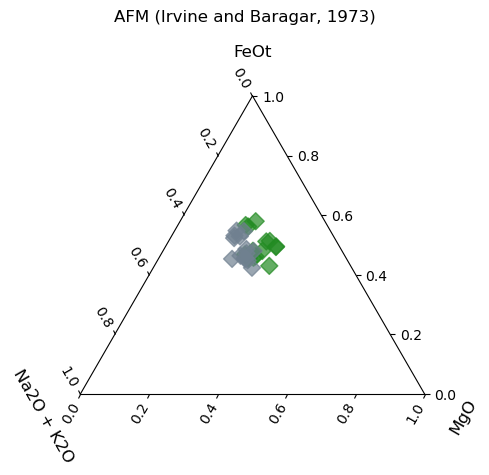

In [68]:
df["FeOt"] = df["Fe2O3"].values * 0.89998


fig,ax = plt.subplots()

for rock in df["Rocknames"].unique():
  df.loc[df["Rocknames"]==rock,["FeOt","Na2O + K2O","MgO"]].pyroplot.scatter(
      color=Color_dict[rock],
      marker="D",
      s=75,
      alpha=0.7,
      edgecolor="black",
      ax=ax
  )

fig.suptitle("AFM (Irvine and Baragar, 1973)")

plt.tight_layout()
plt.show()

### Spidergrams

<Axes: >

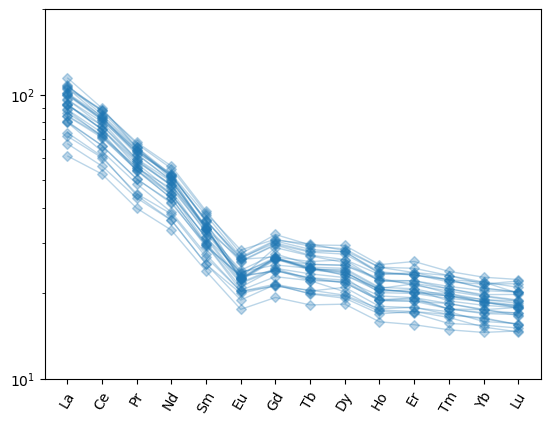

In [70]:
# pyrolite also helps with normalization

df.pyrochem.REE.pyrochem.normalize_to("Chondrite_SM89").pyroplot.spider(alpha=0.3)

(0.9, 500)

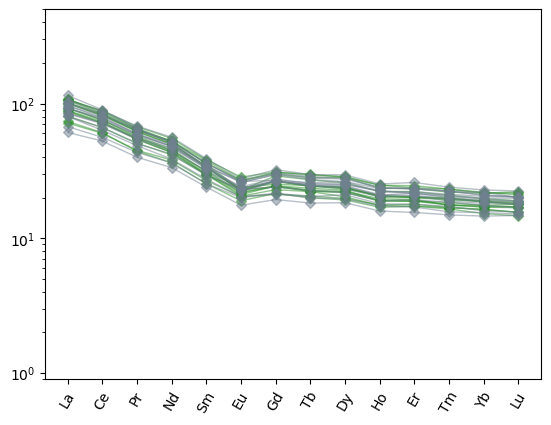

In [72]:
fig, ax = plt.subplots()

for rock in df["Rocknames"].unique():
  df.loc[df["Rocknames"]==rock].pyrochem.REE.pyrochem.normalize_to("Chondrite_SM89").pyroplot.spider(
      ax=ax,
      color=Color_dict[rock],
      marker="D",
      alpha = 0.5
  )

ax.set_ylim(0.9,500)

c:\Users\piero\anaconda3\Lib\site-packages\pyrolite\geochem\transform.py:351: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.76715891 0.58735604 0.6412969  0.61132976 0.80911291 0.85706034
 0.66527062 0.88702749 0.88702749 0.92898149 0.95295521 0.74917862
 0.6412969  0.59334947 0.56937575 0.49745461 0.65328376 0.64729033
 0.73719176 0.82109977 0.79113262 0.62931004 0.69523776 0.65927719
 0.85706034 0.85706034 0.87504063 0.89302092 0.9110012 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  _df.loc[:, targetnames] = subsum.values[:, np.newaxis] @ coeff[np.newaxis, :]
c:\Users\piero\anaconda3\Lib\site-packages\pyrolite\geochem\transform.py:351: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0654631  0.06109889 0.06982731 0.06109889 0.06982731 0.05673469
 0.04364207 0.07419151 0.07419151 0.07855572 0.0

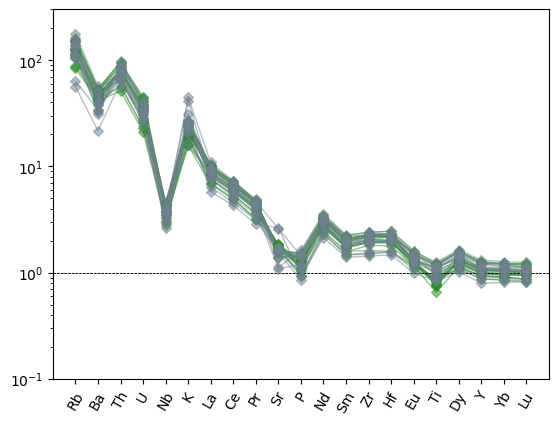

In [ ]:
# We can adopt the same workflow for other incompatible elements
df["Ti"] = df[["TiO2"]].pyrochem.convert_chemistry(to=["Ti"]).values*1e4
df["P"] = df[["P2O5"]].pyrochem.convert_chemistry(to=["P"]).values*1e4
df["K"] = df[["K2O"]].pyrochem.convert_chemistry(to=["K"]).values*1e4



TraceElementList = [
    "Rb","Ba","Th","U","Nb","K","La","Ce","Pr",
    "Sr","P","Nd","Sm","Zr","Hf","Eu","Ti","Dy",
    "Y","Yb","Lu"
]

fig, ax = plt.subplots();

for rock in df["Rocknames"].unique():
  df.loc[df["Rocknames"]==rock,TraceElementList].pyrochem.normalize_to("NMORB_SM89").pyroplot.spider(
      ax=ax,
      color=Color_dict[rock],
      marker="D",
      unity_line=True,
      alpha = 0.5
  );

ax.set_ylim(0.1,300);

We also have the option to color according to a continuous variable

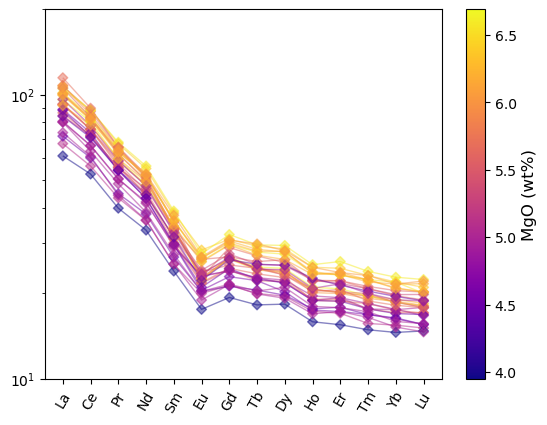

In [83]:
from matplotlib import colors, cm

ax = df.pyrochem.REE.pyrochem.normalize_to("Chondrite_SM89").pyroplot.spider(
    cmap='plasma_r',
    alpha=0.5,
    color=df["MgO"]
)

cmap = cm.plasma
norm = colors.Normalize(
    vmin=df["MgO"].min(),
    vmax=df["MgO"].max())

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="MgO (wt%)")

In [89]:
df.Rocknames

0              Basaltic Andesite
1              Basaltic Andesite
2              Basaltic Andesite
3              Basaltic Andesite
4     Basaltic  Trachy- andesite
5     Basaltic  Trachy- andesite
6     Basaltic  Trachy- andesite
7     Basaltic  Trachy- andesite
8     Basaltic  Trachy- andesite
9              Basaltic Andesite
10    Basaltic  Trachy- andesite
11    Basaltic  Trachy- andesite
12             Basaltic Andesite
13             Basaltic Andesite
14             Basaltic Andesite
15             Basaltic Andesite
16             Basaltic Andesite
17             Basaltic Andesite
18             Basaltic Andesite
19    Basaltic  Trachy- andesite
20    Basaltic  Trachy- andesite
21    Basaltic  Trachy- andesite
22    Basaltic  Trachy- andesite
23             Basaltic Andesite
24    Basaltic  Trachy- andesite
25    Basaltic  Trachy- andesite
26    Basaltic  Trachy- andesite
27             Basaltic Andesite
28             Basaltic Andesite
Name: Rocknames, dtype: object

### Pairplot for quickly exploring correlations

c:\Users\piero\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\piero\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\piero\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\piero\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

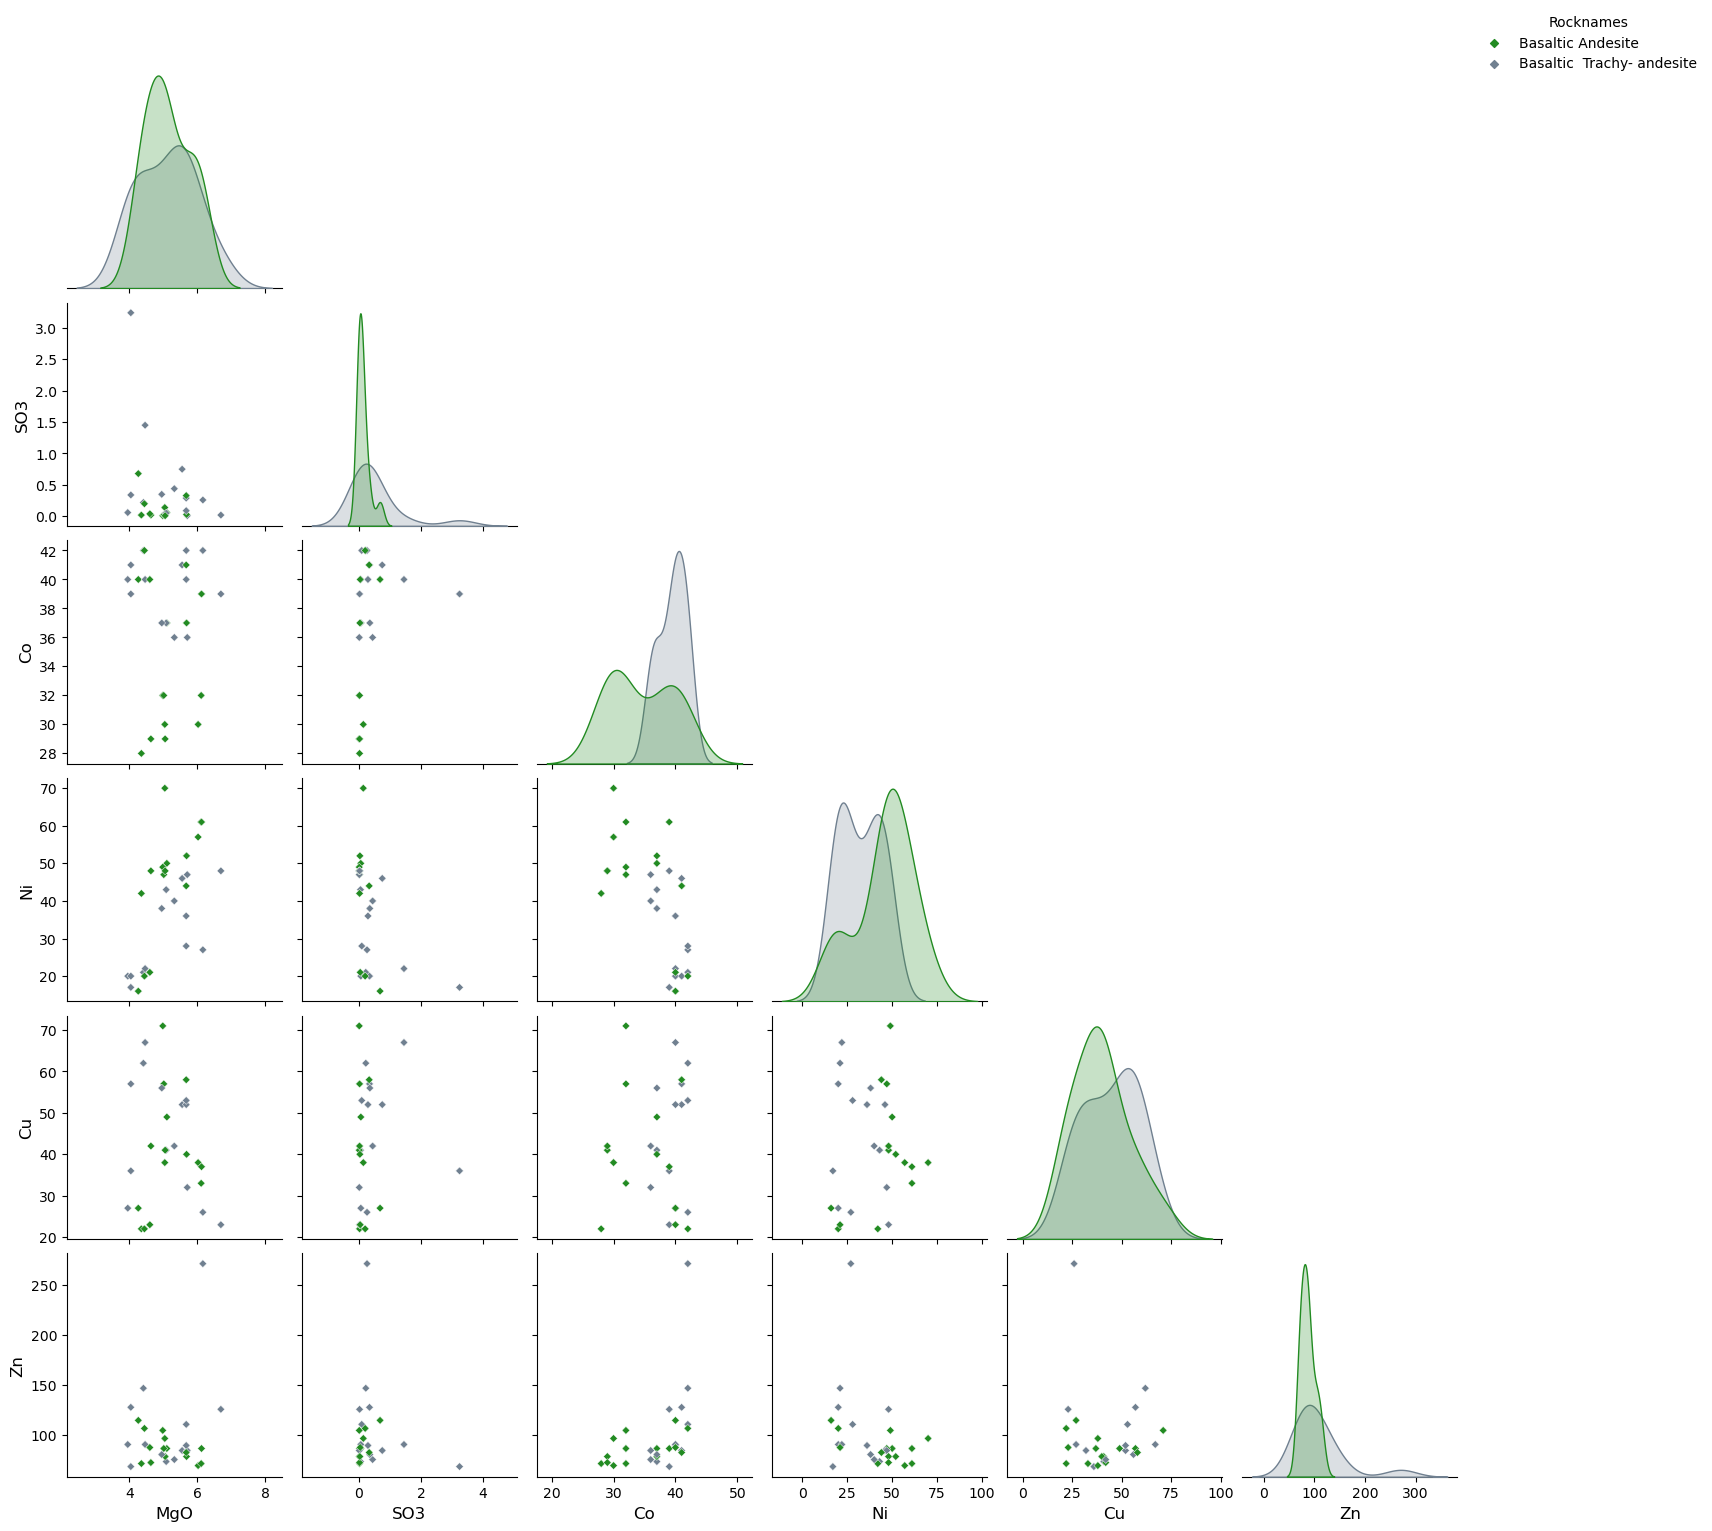

In [94]:
df.pyrochem.compositional.columns

cols = ["MgO", "SO3", "Co", "Ni", "Cu", "Zn", "Rocknames"]

import seaborn as sns

sns.pairplot(df[cols], hue = "Rocknames", palette = Colors, corner = True)

As the drilling campaign was done for Ni-Cu exploration, we can evaluate the grades of these elements at each drill core

Text(0, 0.5, 'Depth (m)')

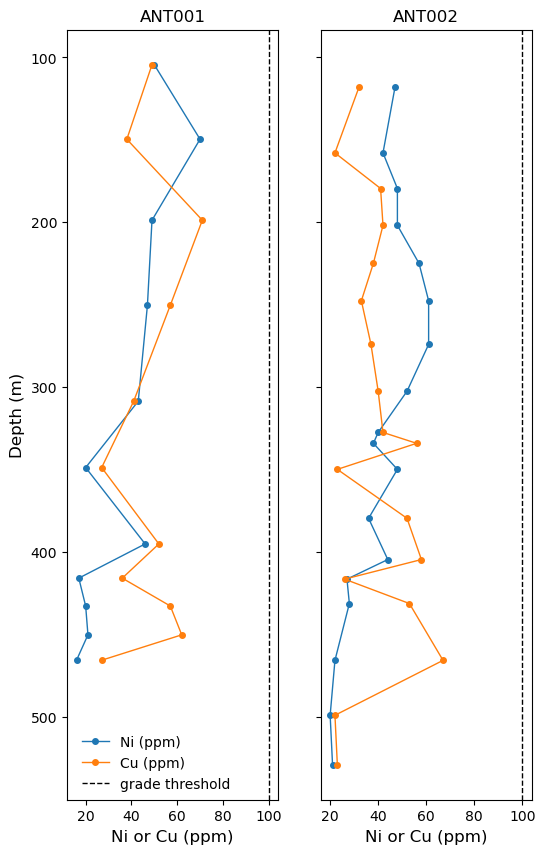

In [137]:
fig, axes = plt.subplots(1,len(df.Location.unique()), figsize = (6,10), sharey = True)



for ax, core in zip(axes, df.Location.unique()):
    dff = df.loc[df.Location == core].sort_values("CentrePoint")

    ax.plot(dff.Ni, dff.CentrePoint, marker="o", label="Ni (ppm)")
    ax.plot(dff.Cu, dff.CentrePoint, marker="o", label="Cu (ppm)")
    ax.axvline(100, ls="--", label="grade threshold", color="black")


    ax.set_title(core)
    ax.set_xlabel("Ni or Cu (ppm)")

# Legend
axes[0].legend(bbox_to_anchor=(0.01, 0.1))

axes[0].invert_yaxis()
axes[0].set_ylabel("Depth (m)")




We can also use python to visualize the stratigraphic chart

In [ ]:
ANT002 = Litho.loc[Litho.hole == "ANT002"]
# Create column for top and base
ANT002 = ANT002.rename({"From":"Top","To":"Base"}, axis = 1)
ANT002["Thickness"] = ANT002.eval("Base - Top").round(2)

ANT002["summary geol"].unique()


,hole,Top,Base,Description,summary geol,Thickness
20,ANT002,0.00,7.00,Grey to brown soil.,soil,7.00
21,ANT002,7.00,24.00,"Silcrete, ferricrete and lateritic clays.",clays,17.00
22,ANT002,24.00,29.50,Possible sediment.,sediment,5.50
23,ANT002,29.50,65.00,"Massive basalt, weathered to 34 m.",basalt,35.50
24,ANT002,65.00,68.00,Amygdaloidal flow top.,basalt,3.00
25,ANT002,68.00,73.50,Massive basalt.,basalt,5.50
26,ANT002,73.50,75.00,Amygdaloidal flow top.,basalt,1.50
27,ANT002,75.00,79.50,Massive basalt.,basalt,4.50
28,ANT002,79.50,86.00,Amygdaloidal flow top.,basalt,6.50
29,ANT002,86.00,328.40,"Massive basalt, coarse-medium grained.",basalt,242.40


In [149]:
import matplotlib.patches as mpatches

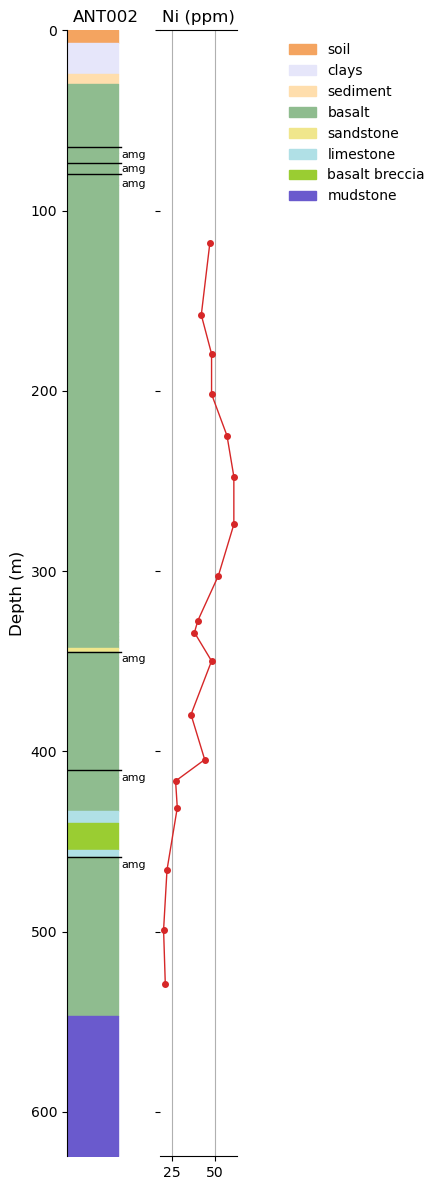

In [194]:

# Define colors for each unique lithology
unique_geol = ANT002["summary geol"].unique()
colors = [
    "sandybrown","lavender","navajowhite","darkseagreen","khaki",
    "powderblue","yellowgreen","slateblue"
]
color_map = {geol: colors[i % len(colors)] for i, geol in enumerate(unique_geol)}

# Plot the stratigraphic column
fig, (ax,ax2) = plt.subplots(1,2,figsize=(5, 12), sharey = True)

for i, row in ANT002.iterrows():
    ax.fill_betweenx([row["Top"], row["Base"]], x1=0, x2=1, color=color_map[row["summary geol"]])
    if row["summary geol"] == "basalt" and "Amyg" in row["Description"]:
        ax.axhline(row["Top"], color = "black", xmax = 0.7)
        ax.text(1.05, (row["Top"] + row["Base"]) / 2, "amg", va='top', fontsize=8)

# Invert y-axis to have the top at the top
ax.set_ylim(ANT002["Base"].max(), 0)
ax.set_xlim(0, 1.5)
ax.set_ylabel("Depth (m)")
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# Add legend
legend_patches = [mpatches.Patch(color=color_map[geol], label=geol) for geol in unique_geol]
ax2.legend(handles=legend_patches, bbox_to_anchor=(1.5, 1), loc='upper left')
ax.set_title("ANT002")


dff = df.loc[df.Location == "ANT002"].sort_values("CentrePoint")

ax2.plot(dff.Ni, dff.CentrePoint, marker="o", label="Ni (ppm)", color = "tab:red")

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False, labeltop = True)
ax2.set_title("Ni (ppm)")
ax2.grid(axis = "x")


plt.tight_layout()
plt.show()